In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the datasets
df_cc = pd.read_csv('../data/processed/creditcard_processed.csv')
df_fraud = pd.read_csv('../data/processed/fraud_data_processed.csv')

Data Preparation

In [44]:
# split the data using stratisfied train-test split
from sklearn.model_selection import train_test_split

# Target
y_fraud = df_fraud['class']

# Drop target and unnecessary columns
x_fraud = df_fraud.drop(
    ["class", "user_id", "signup_time", "purchase_time", "device_id", "country"],
    axis=1,
    errors="ignore"
)

# Keep only numeric & boolean columns
X_fraud = x_fraud.select_dtypes(include=["number", "bool"])

# Fill any NaNs
X_fraud = X_fraud.fillna(0)

# Split
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)



In [10]:
X_cc = df_cc.drop("Class", axis=1)
y_cc = df_cc["Class"]

X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc,
    y_cc,
    test_size=0.2,
    stratify=y_cc,
    random_state=42
)

In [28]:
X_train_fraud

,purchase_value,age,ip_address,hour_of_day,day_of_week,time_since_signup,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,time_diff
50400,-1.415478,-0.596528,1427383584,5,1,-0.354454,False,False,True,False,False,False,False,3823915.0
95942,0.330990,-1.292769,2742229564,16,5,1.336378,False,False,False,False,False,True,True,9109884.0
139235,-1.360900,-0.132367,3967925092,12,0,0.078814,False,True,False,True,False,False,True,5178423.0
28234,2.404920,1.492195,788322671,21,1,0.332005,False,True,False,False,False,False,False,5969962.0
123779,-0.487667,-1.524850,3542045623,21,5,-0.188711,False,True,False,False,False,False,True,4342070.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137952,2.404920,-0.132367,3930389179,17,5,-0.178968,False,False,True,False,False,False,True,4372530.0
13076,-0.160204,1.608235,360880811,22,0,1.655706,False,True,True,False,False,False,True,10108186.0
21982,0.822184,0.911994,604235153,5,5,1.280497,True,False,False,True,False,False,True,8935188.0
9161,1.149646,0.447833,250286249,21,0,-1.321222,False,False,False,True,False,False,True,801556.0


In [47]:
# separate features from target and perform SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_cc_res, y_train_cc_res = smote.fit_resample(X_train_cc, y_train_cc)
X_train_fraud_res, y_train_fraud_res = smote.fit_resample(X_train_fraud, y_train_fraud)


Build Baseline Model

In [31]:
# Train a Logistic Regression model as an interpretable baseline
from sklearn.linear_model import LogisticRegression
lr_cc = LogisticRegression(max_iter=1000, random_state=42)
lr_cc.fit(X_train_cc_res, y_train_cc_res)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [32]:
lr_fraud = LogisticRegression(max_iter=1000, random_state=42)
lr_fraud.fit(X_train_fraud_res, y_train_fraud_res)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [33]:
# Evaluate the model using AUC-PR, F1-Score and Confusion Matrix
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

def evaluate_model(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_test_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    auc_pr = auc(recall, precision)
    f1 = f1_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)

    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"F1-Score: {f1:.4f}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


AUC-PR: 0.7150
F1-Score: 0.1002


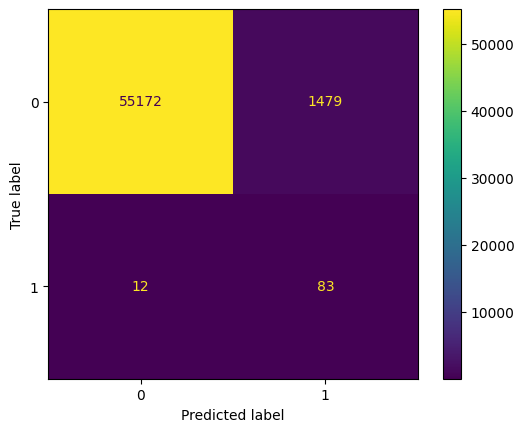

In [34]:
evaluate_model(lr_cc, X_test_cc, y_test_cc)

AUC-PR: 0.2808
F1-Score: 0.3072


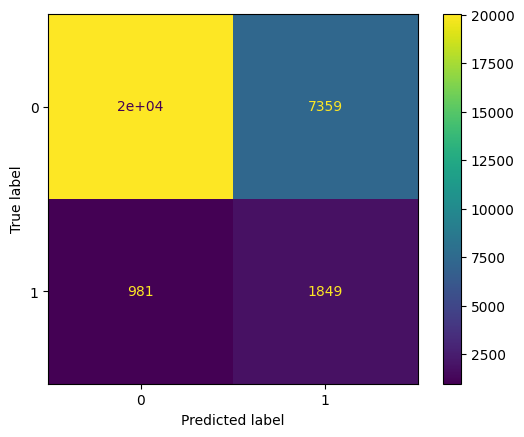

In [35]:
evaluate_model(lr_fraud, X_test_fraud, y_test_fraud)

Build Ensemble Model

In [37]:
# Train one of: Random Forest, XGBoost, or LightGBM
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_cc = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, n_jobs=-1)
rf_cc.fit(X_train_cc_res, y_train_cc_res)

,n_estimators,100
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:

rf_fraud = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, n_jobs=-1 )
rf_fraud.fit(X_train_fraud_res, y_train_fraud_res)

,n_estimators,100
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


AUC-PR: 0.8039
F1-Score: 0.7590


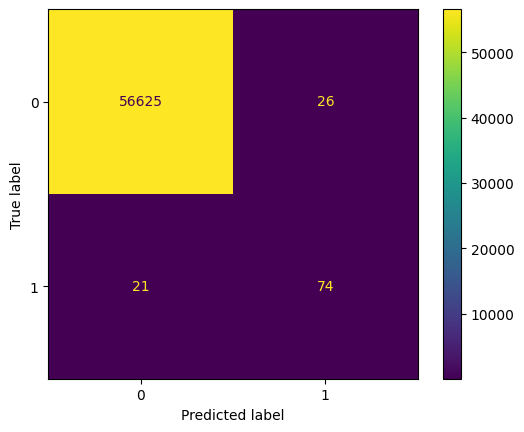

In [42]:
evaluate_model(rf_cc, X_test_cc, y_test_cc)

AUC-PR: 0.6185
F1-Score: 0.5901


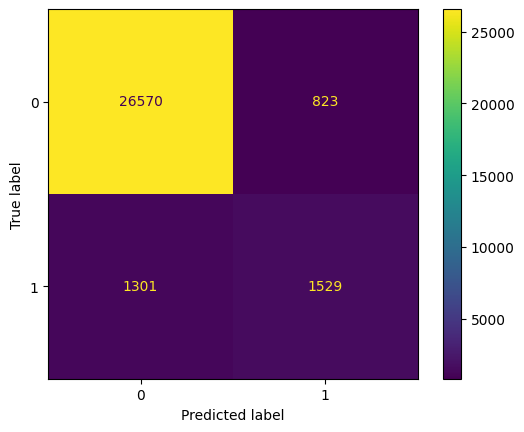

In [50]:
evaluate_model(rf_fraud, X_test_fraud, y_test_fraud)

In [ ]:
# basic hyperparameter tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_cc_random = RandomizedSearchCV(
    estimator=rf_cc,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1)
rf_cc_random.fit(X_train_cc_res, y_train_cc_res)
best_rf_cc = rf_cc_random.best_estimator_
evaluate_model(best_rf_cc, X_test_cc, y_test_cc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
